<table>
<tr>    
<td>
<img src="http://home.agh.edu.pl/~horzyk/im/AdrianHorzyk140h.png" alt="Adrian Horzyk, Professor" title="Adrian Horzyk, Professor" />        
</td> 
<td style="text-align: center">
<h1>Generative Adversarial Network - GAN</h1>
<h2><a href="http://home.agh.edu.pl/~horzyk/index-eng.php">Adrian Horzyk</a></h2>
<h3>Welcome to the interactive lecture where you can check everything by yourself and experiment!</h3>
</td> 
</tr>
</table>

## GAN (Generative Adversarial Network)

GAN (Generative Adversarial Network) networks were introduced in [2014 by Ian Goodfellow](https://arxiv.org/abs/1406.2661) and called ["the most interesting idea in the last 10 years in ML"](https://www.kdnuggets.com/2016/08/yann-lecun-quora-session.html).
The goal of a basic GAN is to mimic the input dataset by generating new samples of data that have a similar feature distribution to the given ones. It's achieved by training two sub-networks that compete against each other in a zero-sum game:
 - discriminator - tries to distinguish real samples from fake ones. It is classification in the most basic GAN approach;
 - generator - creates new samples and tries to deceive the discriminator by making the output as similar to the input dataset as possible.
 
GAN networks can be used to generate images, prose, music, and speech. We can find applications in many artistic and creative fields. On the other hand, it may also become a foundation for creating deepfakes.

---
In this notebook, we'll try to create a solution capable of generating new bird images. For both the generator and the discriminator, convolution and transposed convolution layers are used in order to process images in an efficient way. This version of the GAN network is sometimes called DCGAN (deep-convolutional GAN).

The dataset used in this notebook can be downloaded from [https://data.caltech.edu/records/20098](https://data.caltech.edu/records/20098).

In [1]:
!nvidia-smi

Fri May 26 14:40:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P8    18W / 220W |    391MiB /  4096MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# For linux users:
# !wget -O birds.tgz https://data.caltech.edu/tindfiles/serve/1239ea37-e132-42ee-8c09-c383bb54e7ff/
# !tar zxvf birds.tgz

In [3]:
import tensorflow as tf
from tensorflow import keras, data
from tensorflow.keras import layers, models, utils

import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import pandas as pd
from tqdm import tqdm

Because training even a basic GAN network requires a lot of computational power, all images were scaled to 64x64.   
In this dataset, the authors provide information about bounding boxes of birds in the images, so cropping them will allow us to capture only the most essential features of the images.  
The **LATENT_DIM** variable refers to the size of the noise vector that is going to be passed as an input to the generator network (without random input, the generator would produce the same output each time). This will usually be done in the form of a batch with shape [BATCH_SIZE,LATENT_DIM].

In [16]:
IMG_SIZE=64
BATCH_SIZE=64
LATENT_DIM=100

In [5]:
dataset_path = 'E:/Data/CUB_200_2011/'

# Read txt files containing info about the bounding boxes and the file paths
bboxes = pd.read_csv(dataset_path+'bounding_boxes.txt', sep = " ",names=["id","x","y","width","height"]).astype(int)
annotations = pd.read_csv(dataset_path+'images.txt', sep = " ",names=["id","path"])

processed = []

# Iterate through images, crop, scale and store them in 'processed' array
for index, row in tqdm(annotations.iterrows()):
    image_id = row.id                   #get image id
    image_path = row.path               #get image path
    bbox  = bboxes[bboxes.id == image_id].iloc[0]  #get bounding box values
    
    img = cv2.imread(dataset_path+"images/"+image_path) #read image
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)           #convert to RGB
    img = img[bbox.y:bbox.y+bbox.height,bbox.x:bbox.x+bbox.width,:] #crop image
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))           #resize
    img = tf.cast(img,'float32')/127.5 - 1              #normalize image to [-1,1]
    processed.append(img)                               #store in array

11788it [02:06, 93.48it/s] 


In [17]:
# Create a tensorflow dataset from given data, shuffle images and group them into batches
limit_training = 10000
test = 300

processed = np.array(processed)
np.random.shuffle(processed)

train_dataset = data.Dataset.from_tensor_slices(processed[:limit_training]) \
                .shuffle(1024, reshuffle_each_iteration=True) \
                .batch(BATCH_SIZE)

test_dataset = data.Dataset.from_tensor_slices(processed[limit_training:limit_training + test]).batch(BATCH_SIZE)
print(train_dataset,test_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)> <BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


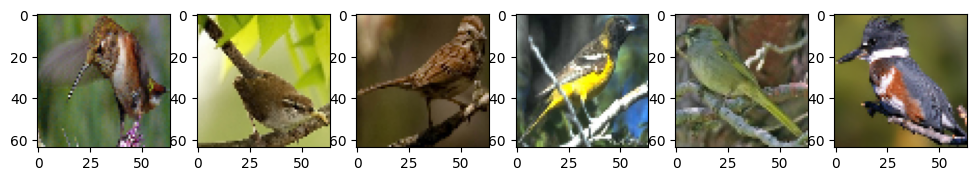

In [18]:
# Take a look at the dataset
imgs = next(iter(test_dataset))
fig = plt.figure(figsize=(12, 8))
rows = 6
for i in range(rows):
    fig.add_subplot(1,rows,i+1)
    plt.imshow((imgs[i]+1)*0.5) #scale images back to [0,1] in order to show them
plt.show()

Creating convolution-based generator and discriminator requires using repeating blocks of some layers.
To provide cleaner and simple code, those layers can be grouped in **Upsample** and **Downsample** blocks.  
Training GAN networks can be a difficult task, and there is no optimal solution, so the presented architecture was chosen arbitrarily. However, there are some general tips that can improve training, for example, by using BatchNormalization, using LeakyReLU in the discriminator and ReLU activation functions in the generator or adding noise to the labels. The influence of each change is out of the scope of this notebook due to the long training time of a single experiment.

In [19]:
class DownsampleBlock(layers.Layer):
    def __init__(self, filters, size, strides=2, padding='same',  use_bn=True):
        super().__init__()
        
        self.stack = keras.Sequential()
        self.stack.add(layers.Conv2D(filters, size, strides, padding))
            
        if use_bn:
            self.stack.add(layers.BatchNormalization(momentum=0.5))

        self.stack.add(layers.LeakyReLU(0.2))

    def call(self, inputs):
        return self.stack(inputs)

In [20]:
class UpsampleBlock(layers.Layer):
    def __init__(self, filters, size=4, strides=2, padding='same', use_bn=True):
        super().__init__()
        
        self.stack = keras.Sequential()
        self.stack.add(layers.Conv2DTranspose(filters, size, strides, padding))
        
        if use_bn:
            self.stack.add(layers.BatchNormalization(momentum=0.5))
            
        self.stack.add(layers.ReLU())

    def call(self, inputs):
        return self.stack(inputs)

Feel free to modify the presented architecture, but please remember that GAN networks are very sensitive, and even small changes can sometimes lead to issues and spoiled training.  
One of the most common issues of GANs is the occurence of "mode collapse" - meaning that generator learns to provide only one kind of output only despite random noise as an input.
![Mode collapse example for MNIST digits dataset](https://api.wandb.ai/files/authors/images/projects/79890/a5fde269.png)
>Mode collapse example for MNIST digits datataset

Another common problem may appear when using Conv2DTranspose layers (inverted convolution that basically scales up the output) in the generator. Sometimes a "checkerboard" pattern appears on the output image.

In [21]:
def create_generator(input_size=LATENT_DIM):
    inp = layers.Input(shape=(input_size,))
    x = layers.Dense(4*4*256)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Reshape((4,4,256))(x)
    x = UpsampleBlock(512,5)(x)
    x = UpsampleBlock(256,5)(x)
    x = UpsampleBlock(128,5)(x)
    x = layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh")(x)
    return keras.models.Model(inp,x,name="generator")

generator = create_generator()

In [22]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 batch_normalization_8 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 upsample_block_3 (UpsampleB  (None, 8, 8, 512)        3279360   
 lock)                                                   

In [23]:
def create_discriminator(input_size=(IMG_SIZE,IMG_SIZE,3)):
    inp = layers.Input(shape=input_size)
    x = DownsampleBlock(64, 5)(inp)
    x = DownsampleBlock(128, 5)(x)
    x = DownsampleBlock(256, 5)(x)
#     x = DownsampleBlock(512, 4)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1,activation='sigmoid')(x)
    return keras.models.Model(inp,x,name="discriminator")


discriminator = create_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 downsample_block_5 (Downsam  (None, 32, 32, 64)       5120      
 pleBlock)                                                       
                                                                 
 downsample_block_6 (Downsam  (None, 16, 16, 128)      205440    
 pleBlock)                                                       
                                                                 
 downsample_block_7 (Downsam  (None, 8, 8, 256)        820480    
 pleBlock)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                     

Architecture choice has a huge impact on the training process because GAN networks are trained in a min-max manner. Each of the two subnetworks can improve only at the cost of the other, so good results can be achieved only at the equilibrium state.  
The too-powerful discriminator will dominate the generator and learn the real image features too quickly to give the generator any chance to find an acceptable and diverse solution.  
The too-weak discriminator will never capture enough features to distinguish between real and fake samples affecting the generator.

### Training overview
In the GAN training process, two main steps can be distinguished:

1. Discriminator training - the generator is used to produce new samples of the data, then the discriminator is feedforwarded with both real and fake batches of samples and outputs classification results (in this notebook, real images are labeled with "1" and generated with "0"). The discriminator's goal is to estimate the probability and distinguish between real and fake results. In this step, only the discriminator weights are updated.

2. Generator training - the generator is fed with some random noise vector and produces new samples that are classified by the discriminator (the discriminator is not trained in this step, it's weights are frozen). At this stage, the generated images are labeled as real ones (1) in order to promote the generator to produce output that makes the discriminator fail. Weight updates for the generator are calculated by backpropagating the error through the discriminator network first (although the discriminator layers stay frozen).
![training process](https://developers.google.com/machine-learning/gan/images/gan_diagram.svg)


The custom GAN model is created in order to implement this procedure which requires manual weight updates in the custom training step.  
Apart from the standard generator and discriminator losses, also the discriminator accuracies are tracked to provide insight into training balance (to check if the discriminator handles well real and fake images).

In [24]:
# Custom GAN model
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        '''Init model'''
        super().__init__()
        
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_optimizer, d_optimizer, g_loss_fn, d_loss_fn, latent_dim, **kwargs):
        '''Initialize metrics, optimizers and losses '''
        super().compile(**kwargs)
        
        self.g_loss_mean = keras.metrics.Mean(name="g_loss")
        self.d_loss_mean = keras.metrics.Mean(name="d_loss")
        
        self.real_acc = keras.metrics.BinaryAccuracy(name="real_acc")
        self.generated_acc = keras.metrics.BinaryAccuracy(name="gen_acc")
        
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        
        # In this example, the same loss function will be provided for both sub-networks (BinaryCrossentropy)
        # However; there are improved GAN variations that use different losses (like WGAN)
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
        self.latent_dim = latent_dim
        
    @property
    def metrics(self):
        return [
            self.g_loss_mean,
            self.d_loss_mean,
            self.real_acc,
            self.generated_acc,
        ]
    
    
    def train_step(self,real_images):
        '''Perform one training step on a single batch of data.'''
        
        batch_size = tf.shape(real_images)[0]
        
        # 1. Train the discriminator
        
        # Generate some images
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim)) # Get noise for generator input
        generated_images = self.generator(random_noise) # Generate images for discriminator training step
        
        
        # Create labels for the discriminator
        # We assume 1 - real image, 0 - fake image + noise (important trick!)
        real_labels = tf.ones((batch_size, 1)) -  tf.random.uniform((batch_size,1)) * 0.15
        generated_labels = tf.random.uniform((batch_size,1)) * 0.15
        

        # Train the network, update weights manually
        # GradientTape is used to record all calculations inside the network and calculate gradient during backprop
        with tf.GradientTape() as tape:            
            # Divide into two steps because of BatchNormalization
            real_preds = self.discriminator(real_images)            # Predict classes for real images
            generated_preds = self.discriminator(generated_images)  # Predict classes for generated images

            # Labels and predictions of [real,fake] are merged for a discriminator loss function
            d_loss = self.d_loss_fn(tf.concat([real_labels,generated_labels],axis=0), # true labels
                                  tf.concat([real_preds,generated_preds],axis=0))     # predicted labels
          
        # Calculate discriminator gradients
        d_grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # Apply weight changes
        self.d_optimizer.apply_gradients(zip(d_grads,self.discriminator.trainable_weights))


        #2. Train the generator
        #[2*] Because discriminator is trained on 2*batch_size number of samples (fake and real)
        random_noise = tf.random.normal(shape=(2*batch_size, self.latent_dim)) #get noise for generator input
        
        
        # During training, the generator tries to deceive the discriminator that it can generate realistic images
        # Therefore, we use "real (1)" labels for the generator
        misleading_labesl = tf.ones((2*batch_size,1))
        
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_noise) # Generate images
            fake_preds = self.discriminator(generated_images,training=False)
            g_loss = self.g_loss_fn(misleading_labesl, fake_preds)  
      
        # Calculate generator gradients
        g_grads = tape.gradient(g_loss, self.generator.trainable_weights)

        # Apply weight changes
        self.g_optimizer.apply_gradients(zip(g_grads,self.generator.trainable_weights))
        
        # Uupdate metrics
        self.g_loss_mean.update_state(g_loss)
        self.d_loss_mean.update_state(d_loss)
        self.real_acc.update_state(1.0, real_preds)
        self.generated_acc.update_state(0.0, generated_preds)
            
        return {'g_loss': g_loss, 'd_loss': d_loss, 
               'real_acc': self.real_acc.result(), 'gen_acc': self.generated_acc.result()}

To track the training progress, two custom Callback is implemented.  
It allows us to see how the generator improves over epochs by plotting images of the same random vector.

In [25]:
class ImageProgress(keras.callbacks.Callback):
    def __init__(self,latent_dim,images=6,every_epoch=10):
        '''Provide latent_dim, number of images to plot and frequency.'''
        self.random_vectors = tf.random.normal((images,latent_dim))
        self.every_epoch = every_epoch
        images

    def on_epoch_end(self, epoch, logs=None):
        if (epoch) % self.every_epoch == 0:
            generated_images = self.model.generator(self.random_vectors,training=False)
        
            fig = plt.figure(figsize=(12, 8))
            for i, image in enumerate(generated_images):
                fig.add_subplot(1,len(self.random_vectors),i+1)
                plt.imshow((image.numpy()+1)*0.5) # Scale output from [-1,1] to [0,1]
            plt.show()

In [26]:
discriminator = create_discriminator()
d_optimizer=keras.optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.9)

generator = create_generator()
g_optimizer=keras.optimizers.Adam(0.00015, beta_1=0.5, beta_2=0.9)

In [27]:
gan = GAN(generator,discriminator)
gan.compile(g_optimizer,
            d_optimizer,
            keras.losses.BinaryCrossentropy(),
            keras.losses.BinaryCrossentropy(),
            LATENT_DIM)

Epoch 1/250
157/157 [==============================] - ETA: 0s - g_loss: 3.7389 - d_loss: 0.2847 - real_acc: 0.9507 - gen_acc: 0.9123

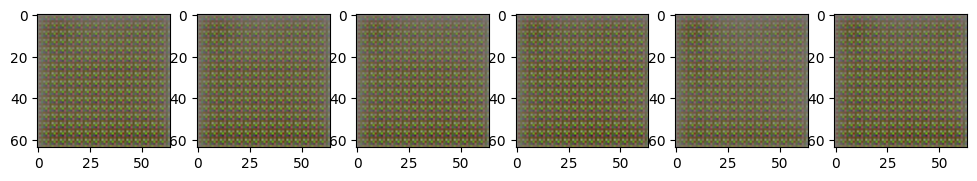

157/157 [==============================] - 56s 320ms/step - g_loss: 3.7389 - d_loss: 0.2847 - real_acc: 0.9507 - gen_acc: 0.9123
Epoch 2/250
157/157 [==============================] - 49s 314ms/step - g_loss: 4.6809 - d_loss: 0.2810 - real_acc: 0.9419 - gen_acc: 0.9644
Epoch 3/250
157/157 [==============================] - 50s 315ms/step - g_loss: 2.9082 - d_loss: 0.4228 - real_acc: 0.9296 - gen_acc: 0.9751
Epoch 4/250
157/157 [==============================] - 50s 316ms/step - g_loss: 3.5054 - d_loss: 0.4044 - real_acc: 0.9152 - gen_acc: 0.9763
Epoch 5/250
157/157 [==============================] - 50s 317ms/step - g_loss: 0.9804 - d_loss: 0.3736 - real_acc: 0.8978 - gen_acc: 0.9785
Epoch 6/250
157/157 [==============================] - 50s 318ms/step - g_loss: 2.4960 - d_loss: 0.5427 - real_acc: 0.8920 - gen_acc: 0.9751
Epoch 7/250
157/157 [==============================] - 50s 318ms/step - g_loss: 2.4650 - d_loss: 0.4176 - real_acc: 0.8620 - gen_acc: 0.9618
Epoch 8/250
157/157 [====

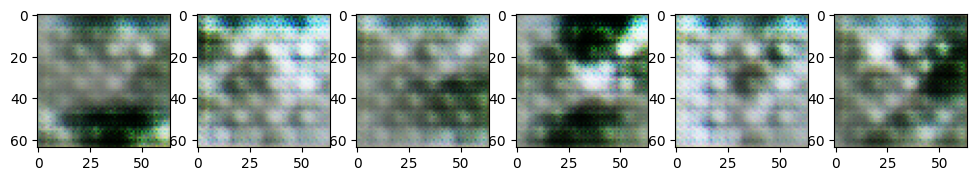

157/157 [==============================] - 51s 322ms/step - g_loss: 3.1013 - d_loss: 0.4041 - real_acc: 0.8085 - gen_acc: 0.9103
Epoch 12/250
157/157 [==============================] - 50s 320ms/step - g_loss: 3.8452 - d_loss: 0.5392 - real_acc: 0.8328 - gen_acc: 0.9290
Epoch 13/250
157/157 [==============================] - 50s 320ms/step - g_loss: 3.5553 - d_loss: 0.4953 - real_acc: 0.8327 - gen_acc: 0.9270
Epoch 14/250
157/157 [==============================] - 50s 320ms/step - g_loss: 3.9623 - d_loss: 0.5646 - real_acc: 0.8371 - gen_acc: 0.9037
Epoch 15/250
157/157 [==============================] - 50s 320ms/step - g_loss: 3.1507 - d_loss: 0.3168 - real_acc: 0.8227 - gen_acc: 0.8813
Epoch 16/250
157/157 [==============================] - 50s 321ms/step - g_loss: 3.3722 - d_loss: 0.3653 - real_acc: 0.8592 - gen_acc: 0.9300
Epoch 17/250
157/157 [==============================] - 50s 321ms/step - g_loss: 3.2472 - d_loss: 0.4503 - real_acc: 0.8789 - gen_acc: 0.9299
Epoch 18/250
157/15

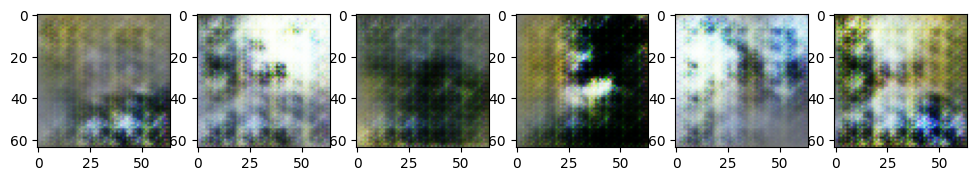

157/157 [==============================] - 51s 324ms/step - g_loss: 3.6051 - d_loss: 0.3754 - real_acc: 0.9192 - gen_acc: 0.9637
Epoch 22/250
157/157 [==============================] - 50s 321ms/step - g_loss: 3.9606 - d_loss: 0.5128 - real_acc: 0.9109 - gen_acc: 0.9526
Epoch 23/250
157/157 [==============================] - 50s 322ms/step - g_loss: 3.5952 - d_loss: 0.3489 - real_acc: 0.9067 - gen_acc: 0.9526
Epoch 24/250
157/157 [==============================] - 51s 322ms/step - g_loss: 3.7364 - d_loss: 0.3326 - real_acc: 0.8806 - gen_acc: 0.9278
Epoch 25/250
157/157 [==============================] - 50s 321ms/step - g_loss: 3.3709 - d_loss: 0.5979 - real_acc: 0.8879 - gen_acc: 0.9318
Epoch 26/250
157/157 [==============================] - 50s 322ms/step - g_loss: 3.1444 - d_loss: 0.3639 - real_acc: 0.8694 - gen_acc: 0.9258
Epoch 27/250
157/157 [==============================] - 50s 321ms/step - g_loss: 2.2386 - d_loss: 0.3800 - real_acc: 0.8866 - gen_acc: 0.9339
Epoch 28/250
157/15

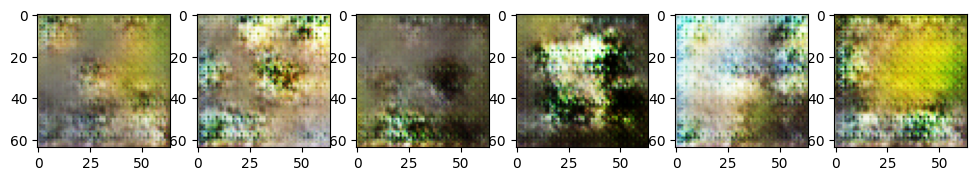

157/157 [==============================] - 51s 325ms/step - g_loss: 2.6919 - d_loss: 0.5355 - real_acc: 0.8393 - gen_acc: 0.9065
Epoch 32/250
157/157 [==============================] - 50s 322ms/step - g_loss: 2.3957 - d_loss: 0.4241 - real_acc: 0.8322 - gen_acc: 0.9042
Epoch 33/250
157/157 [==============================] - 51s 322ms/step - g_loss: 2.9920 - d_loss: 0.5293 - real_acc: 0.8253 - gen_acc: 0.8974
Epoch 34/250
157/157 [==============================] - 51s 322ms/step - g_loss: 2.9168 - d_loss: 0.4648 - real_acc: 0.8150 - gen_acc: 0.8991
Epoch 35/250
157/157 [==============================] - 51s 323ms/step - g_loss: 2.0278 - d_loss: 0.6147 - real_acc: 0.8239 - gen_acc: 0.9035
Epoch 36/250
157/157 [==============================] - 51s 322ms/step - g_loss: 2.2637 - d_loss: 0.4680 - real_acc: 0.8437 - gen_acc: 0.9272
Epoch 37/250
157/157 [==============================] - 51s 322ms/step - g_loss: 2.7489 - d_loss: 0.4680 - real_acc: 0.8210 - gen_acc: 0.9033
Epoch 38/250
157/15

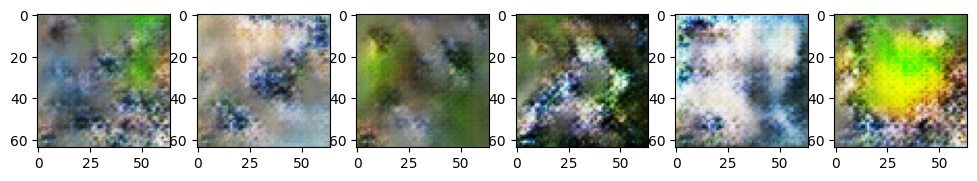

157/157 [==============================] - 51s 324ms/step - g_loss: 3.1530 - d_loss: 0.4968 - real_acc: 0.8473 - gen_acc: 0.9291
Epoch 42/250
157/157 [==============================] - 50s 321ms/step - g_loss: 2.9546 - d_loss: 0.3999 - real_acc: 0.8552 - gen_acc: 0.9391
Epoch 43/250
157/157 [==============================] - 50s 322ms/step - g_loss: 1.9746 - d_loss: 0.3874 - real_acc: 0.8539 - gen_acc: 0.9406
Epoch 44/250
157/157 [==============================] - 50s 321ms/step - g_loss: 2.9916 - d_loss: 0.4976 - real_acc: 0.8627 - gen_acc: 0.9493
Epoch 45/250
157/157 [==============================] - 50s 321ms/step - g_loss: 1.9910 - d_loss: 0.4757 - real_acc: 0.8786 - gen_acc: 0.9553
Epoch 46/250
157/157 [==============================] - 51s 322ms/step - g_loss: 2.4236 - d_loss: 0.4087 - real_acc: 0.8608 - gen_acc: 0.9521
Epoch 47/250
157/157 [==============================] - 50s 321ms/step - g_loss: 2.5197 - d_loss: 0.4562 - real_acc: 0.8809 - gen_acc: 0.9556
Epoch 48/250
157/15

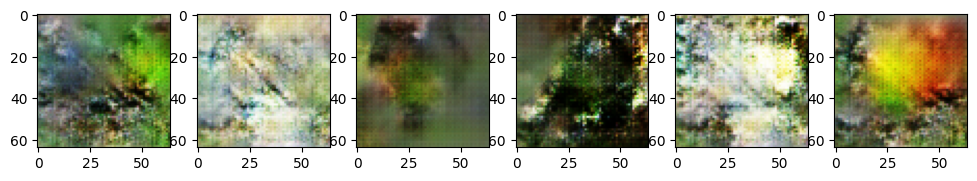

157/157 [==============================] - 51s 325ms/step - g_loss: 2.1306 - d_loss: 0.5524 - real_acc: 0.8874 - gen_acc: 0.9613
Epoch 52/250
157/157 [==============================] - 50s 321ms/step - g_loss: 2.7554 - d_loss: 0.4733 - real_acc: 0.8749 - gen_acc: 0.9630
Epoch 53/250
157/157 [==============================] - 50s 321ms/step - g_loss: 2.7358 - d_loss: 0.3883 - real_acc: 0.8730 - gen_acc: 0.9565
Epoch 54/250
157/157 [==============================] - 50s 321ms/step - g_loss: 2.9448 - d_loss: 0.3617 - real_acc: 0.8688 - gen_acc: 0.9522
Epoch 55/250
157/157 [==============================] - 50s 321ms/step - g_loss: 2.6319 - d_loss: 0.4409 - real_acc: 0.8644 - gen_acc: 0.9509
Epoch 56/250
157/157 [==============================] - 50s 317ms/step - g_loss: nan - d_loss: nan - real_acc: 0.4470 - gen_acc: 0.9780
Epoch 57/250
157/157 [==============================] - 49s 312ms/step - g_loss: nan - d_loss: nan - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 58/250
157/157 [=====

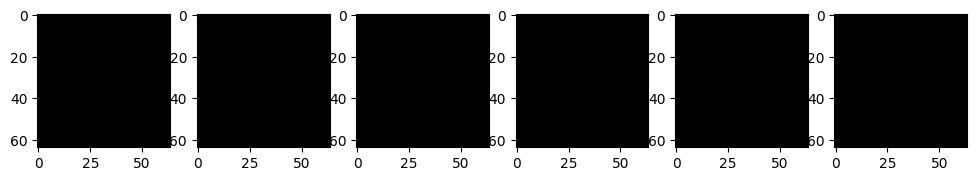

157/157 [==============================] - 49s 314ms/step - g_loss: nan - d_loss: nan - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 62/250
157/157 [==============================] - 49s 312ms/step - g_loss: nan - d_loss: nan - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 63/250
157/157 [==============================] - 49s 312ms/step - g_loss: nan - d_loss: nan - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 64/250
157/157 [==============================] - 49s 312ms/step - g_loss: nan - d_loss: nan - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 65/250
157/157 [==============================] - 49s 312ms/step - g_loss: nan - d_loss: nan - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 66/250
157/157 [==============================] - 49s 312ms/step - g_loss: nan - d_loss: nan - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 67/250
157/157 [==============================] - 49s 312ms/step - g_loss: nan - d_loss: nan - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 68/250
157/157 [===========

In [ ]:
history = gan.fit(train_dataset,
        epochs=250,
        callbacks=[ImageProgress(LATENT_DIM)]) 

In [ ]:
g_loss, d_loss, real_acc, fake_acc = history.history.values()

In [ ]:
generator.save_weights("generator.h5")
discriminator.save_weights("discriminator.h5")

In [ ]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.legend(['Generator loss','Discriminator loss'])
plt.show()

In [ ]:
# Lets take a look at the smoothed plot (Simple Moving Average)

window_size = 20
# Convert array of integers to pandas series
d_sma_loss = pd.Series(d_loss)
g_sma_loss = pd.Series(g_loss)
  
# Get the window of series of observations of the specified window size
d_sma_loss = d_sma_loss.rolling(window_size).mean()
g_sma_loss = g_sma_loss.rolling(window_size).mean()

# Convert pandas series back to list
d_sma_loss = d_sma_loss.tolist()
g_sma_loss = g_sma_loss.tolist()

plt.plot(g_sma_loss)
plt.plot(d_sma_loss)
plt.legend(['Generator loss','Discriminator loss'])
plt.show()

In [ ]:
plt.plot(real_acc)
plt.plot(fake_acc)
plt.legend(['Real images discriminator accuracy','Generated images discriminator accuracy'])
plt.show()

The above plotted loss and accuracies show that the training process of the GAN network is highly unstable. The generator achieved large progress at the beginning by adopting basic image features and then slowed down. The loss plot shows that the network was well-balanced, and both networks converged at some point. Maybe the training could be prolonged for more epochs; however, smoothed plot shows that the generator started downgrading after epoch ~180 in terms of loss.


The accuracies present that at the beginning, it was very easy for the discriminator to distinguish between real data and generated one (basically a noise at the beginning), but then the score dropped due to the quick initial improvement of the generator. Along with the training progress, more details and complex features that the network was adapting started to appear in the images. 

---

Usually, after the training process, there is no longer a need to keep the discriminator; only a trained generator can be now used to produce new data samples.

In [ ]:
noise = tf.random.normal((64,LATENT_DIM))
generated = generator(noise,training=False)
fig = plt.figure(figsize=(12,20))
for i in range(8):
  for j in range(8):
    fig.add_subplot(8,8,i*8+j+1)
    plt.imshow((generated[i*8+j]+1)*0.5)
plt.show()

The presented results should be considered good because only the most basic GAN architecture was used without any regularization or training stabilization methods specific to GANs. Most of the images have bird-like shapes, and some of them are missing details or are full of strange artefacts, but this problem is related to the high complexity of the dataset - 200 kinds of different birds in different poses and non-uniform backgrounds. The basic convolutional approach is also not capable of preserving long-distance relationships between pixels/features on the generated image.  

---

One more example is how manipulation with the latent vector affects the output image. Noise or latent vector given as an input during the training process can encode specific features of the final result.

In [ ]:
# 1. averaging two vectors
examples = 6
noise_1 = np.random.normal(size=(examples,LATENT_DIM))
noise_2 = np.random.normal(size=(examples,LATENT_DIM))
merged = (noise_1 + noise_2)/2 #mean

imgs_1 = generator(noise_1,training=False)
imgs_2 = generator(noise_2,training=False)
result = generator(merged,training=False)

In [ ]:
fig = plt.figure(figsize=(10,5))
for i, (a,b,c) in enumerate(zip(imgs_1,imgs_2,result)):
    fig.add_subplot(3,examples,1+i)
    plt.imshow((a+1)*0.5)
    fig.add_subplot(3,examples,examples+i+1)
    plt.imshow((b+1)*0.5)
    fig.add_subplot(3,examples,2*examples+i+1)
    plt.imshow((c+1)*0.5)

fig.suptitle("Top row - noise A, middle row noise B, bottom row average noise vector from A&B")
plt.show()

Manipulations done with the latent vector are not so obvious. Averaging sometimes produces plausible output with understandable changes like changes in the texture or size of a bird.

In [ ]:
# Feature manipulation (changing single value in the original noise vector) 
noise = np.random.normal(size=(1,LATENT_DIM))
vals = [-2,-1,-0.5,0.5,1,2]                  # values to check
feature = 55                                 # from [0,LATENT_DIM-1]

def plot_feature_change(values,feature,noise):
    fig = plt.figure(figsize=(10,4))
    for index, shift in enumerate(values):
        noise_changed = np.copy(noise)
        noise_changed[0,feature] += shift
        image = generator(noise_changed)
        fig.add_subplot(1,len(vals),1+index)
        plt.imshow((image[0]+1)/2)
        plt.title(shift)
    plt.show()

plot_feature_change(vals,feature,noise)

In [ ]:
plot_feature_change(vals,11,noise)

It's visible that single noise vector values are responsible for the output features like the color of the beak or the body and size of a tail.

In [ ]:
noise = np.random.normal(size=(1,LATENT_DIM)) #new noise
plot_feature_change(vals,11,noise)

Here, changing the same value in different inputs leads to similar results - the gradual transformation of the color. At the same time, it affects other parts of the image, meaning that single values from the noise vector are not always easily explainable to us.

## Assignments (4 points)

* Experiment with some GAN hyperparameters and both networks.
* Show comparisons of the performances of the models and describe your conclusions.
* Try to perform such experiments on a different training dataset, downloaded from <a href="www.kaggle.com">Kaggle.com</a> and fight with overfitting and underfitting.

Send me back the notebook with your solution, presenting your experiments and results in a separate notebook.